# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [9]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

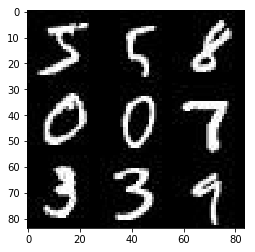

In [91]:
show_n_images = 10

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

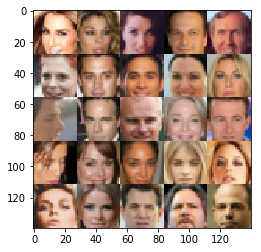

In [92]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [93]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [94]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels)
                                 , name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learn_rate = tf.placeholder(tf.float32, name='l_r')

    return inputs_real, inputs_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [112]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input Layer is 28x28xChannels
        alpha = 0.2
        kern_init = tf.contrib.layers.xavier_initializer()
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=kern_init)
        relu1 = tf.maximum(alpha*x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', kernel_initializer=kern_init)
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha*bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', kernel_initializer=kern_init)
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha*bn3, bn3)
        # 4x4x256
        
        # Flatten
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [111]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse = not is_train):
        alpha = 0.2
        kern_init = tf.contrib.layers.xavier_initializer()
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1)
        # 7x7x256 Now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same', kernel_initializer=kern_init)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        # 14x14x128 Now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same', kernel_initializer=kern_init)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3)
        # 28x28x64 Now
        
        # Output Layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same', kernel_initializer=kern_init)
        # 28x28x3 Now
        
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [114]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [120]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)    
    with tf.control_dependencies(update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [121]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [141]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    # tf.reset_default_graph()
    num, width, height, depth = data_shape
    inputs_real, inputs_z, learn_rate = model_inputs(width, height, depth, z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, depth)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    saver = tf.train.Saver()
    sample_z = tf.random_uniform([10, z_dim], -1, 1)
    #sample_z = tf.constant(np.random.uniform(-1, 1, size=(10, z_dim)), dtype=tf.float64)
    losses = []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_images_norm = batch_images*2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run Optimizer
                _ = sess.run(d_opt, feed_dict={inputs_real: batch_images_norm,
                                               inputs_z: batch_z,
                                               learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={inputs_real: batch_images_norm,
                                               inputs_z: batch_z,
                                               learn_rate: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({inputs_real: batch_images_norm,
                                               inputs_z: batch_z,
                                               learn_rate: learning_rate})
                    train_loss_g = g_loss.eval({inputs_real: batch_images_norm,
                                               inputs_z: batch_z,
                                               learn_rate: learning_rate})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess, 10, sample_z, depth, data_image_mode)
                    
        saver.save(sess, './checkpoints/generator.ckpt')
    return losses 

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 9.8958... Generator Loss: 28.1749
Epoch 1/2... Discriminator Loss: 0.5294... Generator Loss: 2.8630
Epoch 1/2... Discriminator Loss: 0.6755... Generator Loss: 4.3988
Epoch 1/2... Discriminator Loss: 2.3301... Generator Loss: 4.6882
Epoch 1/2... Discriminator Loss: 1.8021... Generator Loss: 0.4663
Epoch 1/2... Discriminator Loss: 2.2036... Generator Loss: 0.2448
Epoch 1/2... Discriminator Loss: 2.2663... Generator Loss: 0.2352
Epoch 1/2... Discriminator Loss: 1.9159... Generator Loss: 0.2981
Epoch 1/2... Discriminator Loss: 1.4553... Generator Loss: 0.6077
Epoch 1/2... Discriminator Loss: 1.6188... Generator Loss: 0.4313


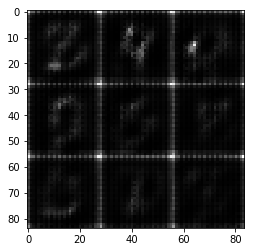

Epoch 1/2... Discriminator Loss: 1.6314... Generator Loss: 0.3840
Epoch 1/2... Discriminator Loss: 1.4081... Generator Loss: 0.5061
Epoch 1/2... Discriminator Loss: 1.4952... Generator Loss: 0.4513
Epoch 1/2... Discriminator Loss: 1.6851... Generator Loss: 0.3708
Epoch 1/2... Discriminator Loss: 1.6571... Generator Loss: 0.4173
Epoch 1/2... Discriminator Loss: 1.3999... Generator Loss: 0.6110
Epoch 1/2... Discriminator Loss: 1.5509... Generator Loss: 0.4367
Epoch 1/2... Discriminator Loss: 1.2708... Generator Loss: 0.7286
Epoch 1/2... Discriminator Loss: 1.4682... Generator Loss: 0.4777
Epoch 1/2... Discriminator Loss: 1.5143... Generator Loss: 0.4417


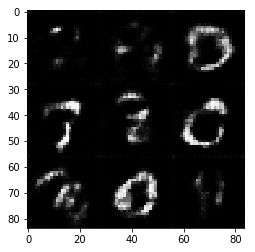

Epoch 1/2... Discriminator Loss: 1.3132... Generator Loss: 0.6273
Epoch 1/2... Discriminator Loss: 1.3567... Generator Loss: 0.6483
Epoch 1/2... Discriminator Loss: 1.6283... Generator Loss: 0.3841
Epoch 1/2... Discriminator Loss: 1.7497... Generator Loss: 0.3614
Epoch 1/2... Discriminator Loss: 1.6227... Generator Loss: 0.3900
Epoch 1/2... Discriminator Loss: 1.3217... Generator Loss: 0.5491
Epoch 1/2... Discriminator Loss: 1.4165... Generator Loss: 0.5316
Epoch 1/2... Discriminator Loss: 1.6344... Generator Loss: 0.3806
Epoch 1/2... Discriminator Loss: 1.6267... Generator Loss: 0.3716
Epoch 1/2... Discriminator Loss: 1.6786... Generator Loss: 0.4051


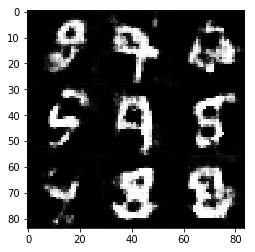

Epoch 1/2... Discriminator Loss: 1.3548... Generator Loss: 0.5163
Epoch 1/2... Discriminator Loss: 1.2643... Generator Loss: 0.6811
Epoch 1/2... Discriminator Loss: 0.9340... Generator Loss: 0.9720
Epoch 1/2... Discriminator Loss: 1.0163... Generator Loss: 1.3314
Epoch 1/2... Discriminator Loss: 0.7822... Generator Loss: 1.7408
Epoch 1/2... Discriminator Loss: 0.9746... Generator Loss: 1.0634
Epoch 1/2... Discriminator Loss: 1.7388... Generator Loss: 0.3572
Epoch 1/2... Discriminator Loss: 0.9266... Generator Loss: 1.1441
Epoch 1/2... Discriminator Loss: 1.1986... Generator Loss: 0.7573
Epoch 1/2... Discriminator Loss: 1.6758... Generator Loss: 0.3659


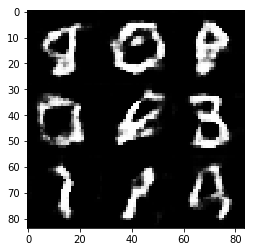

Epoch 1/2... Discriminator Loss: 1.3328... Generator Loss: 0.5542
Epoch 1/2... Discriminator Loss: 1.2342... Generator Loss: 1.9118
Epoch 1/2... Discriminator Loss: 1.1319... Generator Loss: 2.4837
Epoch 1/2... Discriminator Loss: 1.2631... Generator Loss: 1.3370
Epoch 1/2... Discriminator Loss: 0.9227... Generator Loss: 1.8080
Epoch 1/2... Discriminator Loss: 1.3719... Generator Loss: 1.4179
Epoch 1/2... Discriminator Loss: 1.2593... Generator Loss: 1.0821
Epoch 1/2... Discriminator Loss: 1.4175... Generator Loss: 1.5566
Epoch 1/2... Discriminator Loss: 1.1440... Generator Loss: 0.9548
Epoch 1/2... Discriminator Loss: 1.2032... Generator Loss: 1.0813


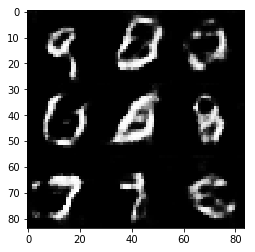

Epoch 1/2... Discriminator Loss: 1.5775... Generator Loss: 0.4023
Epoch 1/2... Discriminator Loss: 1.2975... Generator Loss: 0.5981
Epoch 1/2... Discriminator Loss: 1.4165... Generator Loss: 0.5110
Epoch 1/2... Discriminator Loss: 1.4063... Generator Loss: 0.5152
Epoch 1/2... Discriminator Loss: 1.2169... Generator Loss: 0.7158
Epoch 1/2... Discriminator Loss: 1.6483... Generator Loss: 1.8421
Epoch 1/2... Discriminator Loss: 1.6562... Generator Loss: 0.3736
Epoch 1/2... Discriminator Loss: 1.4194... Generator Loss: 0.4836
Epoch 1/2... Discriminator Loss: 1.5348... Generator Loss: 0.4019
Epoch 1/2... Discriminator Loss: 1.3513... Generator Loss: 0.5538


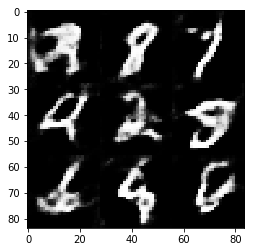

Epoch 1/2... Discriminator Loss: 1.2284... Generator Loss: 0.7992
Epoch 1/2... Discriminator Loss: 1.2102... Generator Loss: 1.2631
Epoch 1/2... Discriminator Loss: 1.2475... Generator Loss: 0.8438
Epoch 1/2... Discriminator Loss: 1.4136... Generator Loss: 0.5149
Epoch 1/2... Discriminator Loss: 1.5077... Generator Loss: 0.4412
Epoch 1/2... Discriminator Loss: 1.4331... Generator Loss: 0.4897
Epoch 1/2... Discriminator Loss: 1.4419... Generator Loss: 0.5119
Epoch 1/2... Discriminator Loss: 1.3201... Generator Loss: 0.6348
Epoch 1/2... Discriminator Loss: 1.4343... Generator Loss: 0.4888
Epoch 1/2... Discriminator Loss: 1.5072... Generator Loss: 0.4621


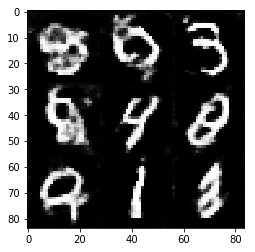

Epoch 1/2... Discriminator Loss: 1.5366... Generator Loss: 0.4351
Epoch 1/2... Discriminator Loss: 1.2342... Generator Loss: 1.2086
Epoch 1/2... Discriminator Loss: 1.4883... Generator Loss: 1.7263
Epoch 1/2... Discriminator Loss: 1.1489... Generator Loss: 1.0541
Epoch 1/2... Discriminator Loss: 1.2276... Generator Loss: 1.1488
Epoch 1/2... Discriminator Loss: 1.1508... Generator Loss: 1.7099
Epoch 1/2... Discriminator Loss: 1.1761... Generator Loss: 0.6880
Epoch 1/2... Discriminator Loss: 1.9029... Generator Loss: 1.8211
Epoch 1/2... Discriminator Loss: 1.3016... Generator Loss: 0.6578
Epoch 1/2... Discriminator Loss: 1.3647... Generator Loss: 1.6231


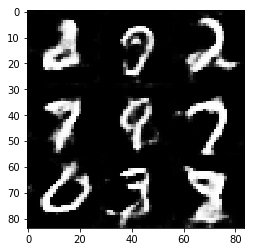

Epoch 1/2... Discriminator Loss: 1.1353... Generator Loss: 1.0347
Epoch 1/2... Discriminator Loss: 1.3750... Generator Loss: 0.5525
Epoch 1/2... Discriminator Loss: 1.5799... Generator Loss: 0.4144
Epoch 1/2... Discriminator Loss: 1.0544... Generator Loss: 0.9268
Epoch 1/2... Discriminator Loss: 1.2061... Generator Loss: 1.1060
Epoch 1/2... Discriminator Loss: 1.5493... Generator Loss: 0.4627
Epoch 1/2... Discriminator Loss: 1.4455... Generator Loss: 1.3489
Epoch 1/2... Discriminator Loss: 1.2530... Generator Loss: 0.6899
Epoch 1/2... Discriminator Loss: 1.3833... Generator Loss: 0.5474
Epoch 1/2... Discriminator Loss: 1.3994... Generator Loss: 0.5235


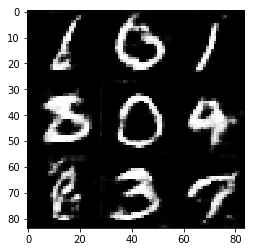

Epoch 1/2... Discriminator Loss: 1.2647... Generator Loss: 1.3864
Epoch 1/2... Discriminator Loss: 1.2669... Generator Loss: 1.8332
Epoch 1/2... Discriminator Loss: 1.2390... Generator Loss: 1.3134
Epoch 2/2... Discriminator Loss: 1.6330... Generator Loss: 0.3861
Epoch 2/2... Discriminator Loss: 1.2702... Generator Loss: 0.6408
Epoch 2/2... Discriminator Loss: 1.4984... Generator Loss: 0.4479
Epoch 2/2... Discriminator Loss: 1.3556... Generator Loss: 0.5591
Epoch 2/2... Discriminator Loss: 1.8856... Generator Loss: 0.3124
Epoch 2/2... Discriminator Loss: 1.5199... Generator Loss: 0.4403
Epoch 2/2... Discriminator Loss: 1.2787... Generator Loss: 0.6488


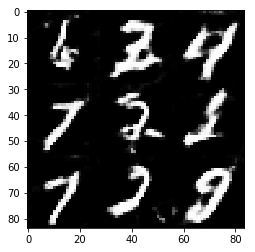

Epoch 2/2... Discriminator Loss: 1.1507... Generator Loss: 1.5046
Epoch 2/2... Discriminator Loss: 1.2029... Generator Loss: 1.4173
Epoch 2/2... Discriminator Loss: 0.9864... Generator Loss: 1.0917
Epoch 2/2... Discriminator Loss: 1.2012... Generator Loss: 1.1057
Epoch 2/2... Discriminator Loss: 1.2027... Generator Loss: 1.5141
Epoch 2/2... Discriminator Loss: 1.2858... Generator Loss: 0.6146
Epoch 2/2... Discriminator Loss: 1.6209... Generator Loss: 0.3848
Epoch 2/2... Discriminator Loss: 1.8528... Generator Loss: 0.2985
Epoch 2/2... Discriminator Loss: 1.0896... Generator Loss: 1.2118
Epoch 2/2... Discriminator Loss: 1.3040... Generator Loss: 0.5583


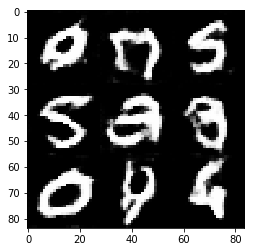

Epoch 2/2... Discriminator Loss: 1.9209... Generator Loss: 0.3707
Epoch 2/2... Discriminator Loss: 1.1109... Generator Loss: 1.1063
Epoch 2/2... Discriminator Loss: 1.3752... Generator Loss: 0.5205
Epoch 2/2... Discriminator Loss: 1.4249... Generator Loss: 0.4891
Epoch 2/2... Discriminator Loss: 1.4188... Generator Loss: 0.5385
Epoch 2/2... Discriminator Loss: 1.3835... Generator Loss: 0.5372
Epoch 2/2... Discriminator Loss: 1.2136... Generator Loss: 0.7593
Epoch 2/2... Discriminator Loss: 1.3406... Generator Loss: 0.5652
Epoch 2/2... Discriminator Loss: 1.6968... Generator Loss: 0.3568
Epoch 2/2... Discriminator Loss: 1.1596... Generator Loss: 0.7447


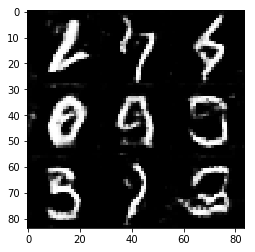

Epoch 2/2... Discriminator Loss: 1.0124... Generator Loss: 1.1879
Epoch 2/2... Discriminator Loss: 1.5276... Generator Loss: 0.4663
Epoch 2/2... Discriminator Loss: 1.5199... Generator Loss: 0.4796
Epoch 2/2... Discriminator Loss: 1.1971... Generator Loss: 0.8052
Epoch 2/2... Discriminator Loss: 1.2468... Generator Loss: 0.6571
Epoch 2/2... Discriminator Loss: 1.2300... Generator Loss: 0.7893
Epoch 2/2... Discriminator Loss: 1.2468... Generator Loss: 0.7391
Epoch 2/2... Discriminator Loss: 1.7524... Generator Loss: 0.3475
Epoch 2/2... Discriminator Loss: 0.9895... Generator Loss: 1.2144
Epoch 2/2... Discriminator Loss: 1.1708... Generator Loss: 1.6373


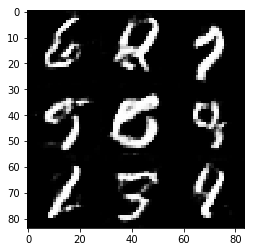

Epoch 2/2... Discriminator Loss: 1.2463... Generator Loss: 1.1152
Epoch 2/2... Discriminator Loss: 1.2096... Generator Loss: 1.6772
Epoch 2/2... Discriminator Loss: 1.1317... Generator Loss: 0.7829
Epoch 2/2... Discriminator Loss: 0.9565... Generator Loss: 1.0300
Epoch 2/2... Discriminator Loss: 1.7594... Generator Loss: 0.3554
Epoch 2/2... Discriminator Loss: 1.3319... Generator Loss: 0.5947
Epoch 2/2... Discriminator Loss: 1.5357... Generator Loss: 0.4219
Epoch 2/2... Discriminator Loss: 1.1086... Generator Loss: 1.0083
Epoch 2/2... Discriminator Loss: 1.5035... Generator Loss: 0.4577
Epoch 2/2... Discriminator Loss: 1.3579... Generator Loss: 1.7610


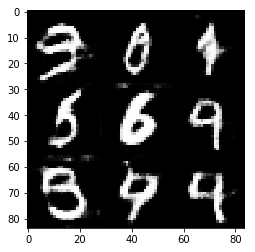

Epoch 2/2... Discriminator Loss: 1.3990... Generator Loss: 2.1280
Epoch 2/2... Discriminator Loss: 1.1592... Generator Loss: 0.6903
Epoch 2/2... Discriminator Loss: 0.9809... Generator Loss: 1.0742
Epoch 2/2... Discriminator Loss: 1.7697... Generator Loss: 0.3365
Epoch 2/2... Discriminator Loss: 1.3982... Generator Loss: 0.5264
Epoch 2/2... Discriminator Loss: 1.3451... Generator Loss: 0.5970
Epoch 2/2... Discriminator Loss: 1.6033... Generator Loss: 0.3905
Epoch 2/2... Discriminator Loss: 1.0702... Generator Loss: 0.8811
Epoch 2/2... Discriminator Loss: 0.9497... Generator Loss: 1.0605
Epoch 2/2... Discriminator Loss: 1.4657... Generator Loss: 1.9505


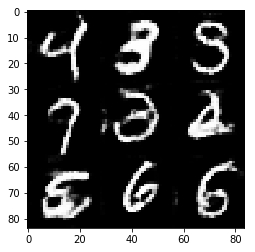

Epoch 2/2... Discriminator Loss: 1.1174... Generator Loss: 1.0067
Epoch 2/2... Discriminator Loss: 1.0045... Generator Loss: 1.3083
Epoch 2/2... Discriminator Loss: 1.1335... Generator Loss: 1.6146
Epoch 2/2... Discriminator Loss: 1.0978... Generator Loss: 1.1108
Epoch 2/2... Discriminator Loss: 1.2768... Generator Loss: 0.5782
Epoch 2/2... Discriminator Loss: 1.5206... Generator Loss: 0.4768
Epoch 2/2... Discriminator Loss: 1.1105... Generator Loss: 1.3796
Epoch 2/2... Discriminator Loss: 1.0286... Generator Loss: 1.0465
Epoch 2/2... Discriminator Loss: 1.1098... Generator Loss: 1.3960
Epoch 2/2... Discriminator Loss: 1.1081... Generator Loss: 0.8467


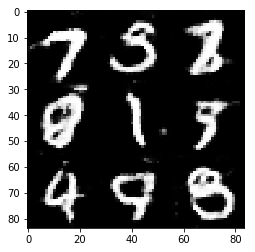

Epoch 2/2... Discriminator Loss: 1.2663... Generator Loss: 0.8233
Epoch 2/2... Discriminator Loss: 1.3371... Generator Loss: 2.0923
Epoch 2/2... Discriminator Loss: 1.4794... Generator Loss: 0.5153
Epoch 2/2... Discriminator Loss: 1.4427... Generator Loss: 0.5215
Epoch 2/2... Discriminator Loss: 1.3838... Generator Loss: 0.5248
Epoch 2/2... Discriminator Loss: 1.0858... Generator Loss: 1.4218
Epoch 2/2... Discriminator Loss: 1.0367... Generator Loss: 0.8067
Epoch 2/2... Discriminator Loss: 1.8124... Generator Loss: 0.3112
Epoch 2/2... Discriminator Loss: 1.1805... Generator Loss: 0.6822
Epoch 2/2... Discriminator Loss: 1.1248... Generator Loss: 0.7834


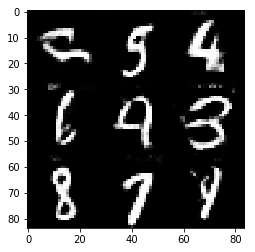

Epoch 2/2... Discriminator Loss: 1.5722... Generator Loss: 0.4674
Epoch 2/2... Discriminator Loss: 1.2740... Generator Loss: 0.6742
Epoch 2/2... Discriminator Loss: 1.3800... Generator Loss: 0.5583
Epoch 2/2... Discriminator Loss: 1.1743... Generator Loss: 1.1691
Epoch 2/2... Discriminator Loss: 1.2812... Generator Loss: 1.9150
Epoch 2/2... Discriminator Loss: 1.0682... Generator Loss: 0.8202
Epoch 2/2... Discriminator Loss: 1.0681... Generator Loss: 1.1409
Epoch 2/2... Discriminator Loss: 1.3429... Generator Loss: 0.5541
Epoch 2/2... Discriminator Loss: 1.0087... Generator Loss: 0.8674
Epoch 2/2... Discriminator Loss: 1.3454... Generator Loss: 1.0801


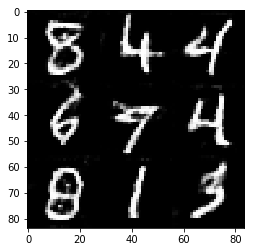

Epoch 2/2... Discriminator Loss: 1.2390... Generator Loss: 0.7951
Epoch 2/2... Discriminator Loss: 1.1344... Generator Loss: 0.9186
Epoch 2/2... Discriminator Loss: 1.4304... Generator Loss: 0.4912
Epoch 2/2... Discriminator Loss: 1.1606... Generator Loss: 0.7417
Epoch 2/2... Discriminator Loss: 1.2559... Generator Loss: 0.7391
Epoch 2/2... Discriminator Loss: 1.1863... Generator Loss: 1.3699
Epoch 2/2... Discriminator Loss: 0.8823... Generator Loss: 1.4627


In [142]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.4419... Generator Loss: 1.0205
Epoch 1/1... Discriminator Loss: 2.8059... Generator Loss: 12.0874
Epoch 1/1... Discriminator Loss: 2.8512... Generator Loss: 0.1214
Epoch 1/1... Discriminator Loss: 1.6559... Generator Loss: 2.6955
Epoch 1/1... Discriminator Loss: 1.0326... Generator Loss: 1.2007
Epoch 1/1... Discriminator Loss: 1.0046... Generator Loss: 3.1420
Epoch 1/1... Discriminator Loss: 0.7822... Generator Loss: 1.3824
Epoch 1/1... Discriminator Loss: 0.9733... Generator Loss: 0.9965
Epoch 1/1... Discriminator Loss: 3.6702... Generator Loss: 6.3044
Epoch 1/1... Discriminator Loss: 1.1665... Generator Loss: 1.2289


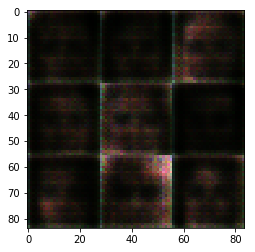

Epoch 1/1... Discriminator Loss: 1.6038... Generator Loss: 5.0711
Epoch 1/1... Discriminator Loss: 0.7677... Generator Loss: 1.6937
Epoch 1/1... Discriminator Loss: 0.9734... Generator Loss: 3.4046
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.6371
Epoch 1/1... Discriminator Loss: 0.7465... Generator Loss: 3.8463
Epoch 1/1... Discriminator Loss: 1.2158... Generator Loss: 1.2065
Epoch 1/1... Discriminator Loss: 1.2795... Generator Loss: 1.1540
Epoch 1/1... Discriminator Loss: 0.7810... Generator Loss: 1.2263
Epoch 1/1... Discriminator Loss: 1.3296... Generator Loss: 0.5556
Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 1.6096


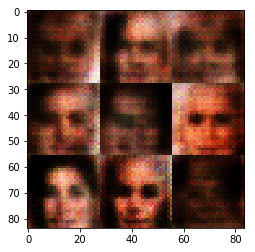

Epoch 1/1... Discriminator Loss: 0.7980... Generator Loss: 1.2442
Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 2.0187
Epoch 1/1... Discriminator Loss: 1.1544... Generator Loss: 0.8403
Epoch 1/1... Discriminator Loss: 1.0775... Generator Loss: 1.0466
Epoch 1/1... Discriminator Loss: 1.1830... Generator Loss: 1.0142
Epoch 1/1... Discriminator Loss: 0.8436... Generator Loss: 1.0918
Epoch 1/1... Discriminator Loss: 0.8847... Generator Loss: 1.1138
Epoch 1/1... Discriminator Loss: 1.2355... Generator Loss: 1.5525
Epoch 1/1... Discriminator Loss: 1.1913... Generator Loss: 0.7029
Epoch 1/1... Discriminator Loss: 1.3514... Generator Loss: 0.5582


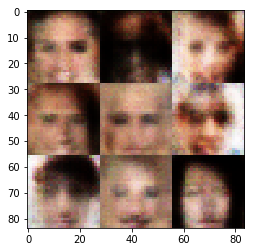

Epoch 1/1... Discriminator Loss: 0.7008... Generator Loss: 1.9415
Epoch 1/1... Discriminator Loss: 1.7973... Generator Loss: 2.4645
Epoch 1/1... Discriminator Loss: 1.1603... Generator Loss: 0.7001
Epoch 1/1... Discriminator Loss: 0.8113... Generator Loss: 2.3898
Epoch 1/1... Discriminator Loss: 2.8511... Generator Loss: 3.8476
Epoch 1/1... Discriminator Loss: 1.3388... Generator Loss: 0.5333
Epoch 1/1... Discriminator Loss: 1.9333... Generator Loss: 2.4518
Epoch 1/1... Discriminator Loss: 0.8324... Generator Loss: 1.2266
Epoch 1/1... Discriminator Loss: 1.8186... Generator Loss: 2.2621
Epoch 1/1... Discriminator Loss: 1.2570... Generator Loss: 0.6216


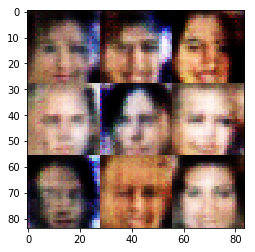

Epoch 1/1... Discriminator Loss: 2.2550... Generator Loss: 2.5101
Epoch 1/1... Discriminator Loss: 1.1566... Generator Loss: 0.9991
Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 1.9115
Epoch 1/1... Discriminator Loss: 1.1120... Generator Loss: 1.1030
Epoch 1/1... Discriminator Loss: 1.4822... Generator Loss: 0.4539
Epoch 1/1... Discriminator Loss: 1.0688... Generator Loss: 1.0300
Epoch 1/1... Discriminator Loss: 1.5291... Generator Loss: 1.3842
Epoch 1/1... Discriminator Loss: 1.3250... Generator Loss: 0.8018
Epoch 1/1... Discriminator Loss: 1.2276... Generator Loss: 0.7945
Epoch 1/1... Discriminator Loss: 1.0458... Generator Loss: 1.1322


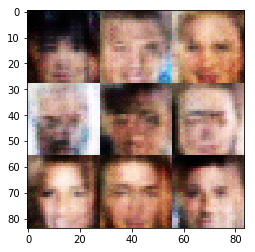

Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.7051
Epoch 1/1... Discriminator Loss: 1.3608... Generator Loss: 0.8982
Epoch 1/1... Discriminator Loss: 0.8753... Generator Loss: 1.6812
Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 0.6540
Epoch 1/1... Discriminator Loss: 0.8249... Generator Loss: 1.2285
Epoch 1/1... Discriminator Loss: 1.3281... Generator Loss: 0.7382
Epoch 1/1... Discriminator Loss: 1.1423... Generator Loss: 1.4934
Epoch 1/1... Discriminator Loss: 1.1867... Generator Loss: 1.8594
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.5270
Epoch 1/1... Discriminator Loss: 1.1820... Generator Loss: 1.2177


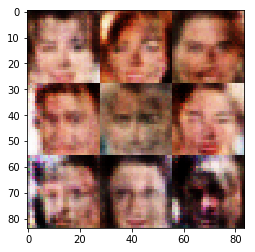

Epoch 1/1... Discriminator Loss: 1.2535... Generator Loss: 0.7463
Epoch 1/1... Discriminator Loss: 1.0899... Generator Loss: 1.2819
Epoch 1/1... Discriminator Loss: 1.2462... Generator Loss: 0.6269
Epoch 1/1... Discriminator Loss: 1.1281... Generator Loss: 1.0561
Epoch 1/1... Discriminator Loss: 1.3087... Generator Loss: 0.6750
Epoch 1/1... Discriminator Loss: 0.8782... Generator Loss: 2.2031
Epoch 1/1... Discriminator Loss: 1.0438... Generator Loss: 0.8122
Epoch 1/1... Discriminator Loss: 1.7694... Generator Loss: 0.4017
Epoch 1/1... Discriminator Loss: 1.1133... Generator Loss: 1.5308
Epoch 1/1... Discriminator Loss: 1.3298... Generator Loss: 1.2184


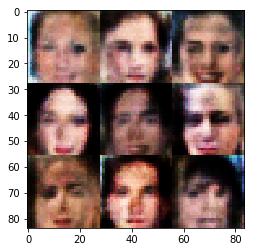

Epoch 1/1... Discriminator Loss: 1.3157... Generator Loss: 1.1298
Epoch 1/1... Discriminator Loss: 1.0111... Generator Loss: 1.2257
Epoch 1/1... Discriminator Loss: 1.2272... Generator Loss: 1.0104
Epoch 1/1... Discriminator Loss: 1.6245... Generator Loss: 1.2686
Epoch 1/1... Discriminator Loss: 0.8696... Generator Loss: 2.5629
Epoch 1/1... Discriminator Loss: 1.3686... Generator Loss: 1.2690
Epoch 1/1... Discriminator Loss: 1.1218... Generator Loss: 1.1158
Epoch 1/1... Discriminator Loss: 1.0640... Generator Loss: 0.9980
Epoch 1/1... Discriminator Loss: 1.6756... Generator Loss: 0.3587
Epoch 1/1... Discriminator Loss: 1.4478... Generator Loss: 0.9601


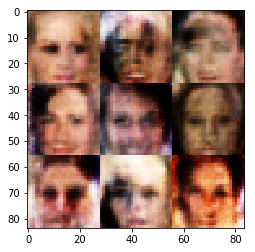

Epoch 1/1... Discriminator Loss: 1.1298... Generator Loss: 0.7464
Epoch 1/1... Discriminator Loss: 0.7911... Generator Loss: 1.2758
Epoch 1/1... Discriminator Loss: 1.7664... Generator Loss: 0.3165
Epoch 1/1... Discriminator Loss: 0.9623... Generator Loss: 1.9820
Epoch 1/1... Discriminator Loss: 0.7618... Generator Loss: 1.3155
Epoch 1/1... Discriminator Loss: 1.1334... Generator Loss: 0.6784
Epoch 1/1... Discriminator Loss: 1.0497... Generator Loss: 1.2971
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 2.5627
Epoch 1/1... Discriminator Loss: 0.4984... Generator Loss: 2.4077
Epoch 1/1... Discriminator Loss: 1.2688... Generator Loss: 0.9820


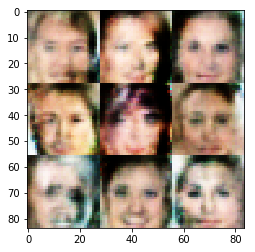

Epoch 1/1... Discriminator Loss: 1.4549... Generator Loss: 2.0300
Epoch 1/1... Discriminator Loss: 0.8576... Generator Loss: 1.0424
Epoch 1/1... Discriminator Loss: 1.9398... Generator Loss: 3.1034
Epoch 1/1... Discriminator Loss: 1.1190... Generator Loss: 0.6867
Epoch 1/1... Discriminator Loss: 0.6748... Generator Loss: 1.3133
Epoch 1/1... Discriminator Loss: 0.6869... Generator Loss: 1.3533
Epoch 1/1... Discriminator Loss: 0.7434... Generator Loss: 3.2734
Epoch 1/1... Discriminator Loss: 0.8303... Generator Loss: 1.1737
Epoch 1/1... Discriminator Loss: 0.6663... Generator Loss: 1.5930
Epoch 1/1... Discriminator Loss: 0.7190... Generator Loss: 1.5574


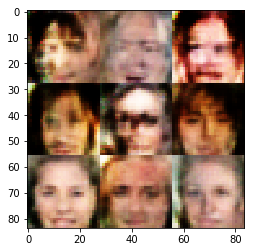

Epoch 1/1... Discriminator Loss: 1.0347... Generator Loss: 3.2005
Epoch 1/1... Discriminator Loss: 1.1306... Generator Loss: 0.8026
Epoch 1/1... Discriminator Loss: 1.0913... Generator Loss: 0.7459
Epoch 1/1... Discriminator Loss: 1.0595... Generator Loss: 0.9662
Epoch 1/1... Discriminator Loss: 0.8234... Generator Loss: 1.4610
Epoch 1/1... Discriminator Loss: 1.0021... Generator Loss: 0.9005
Epoch 1/1... Discriminator Loss: 1.1517... Generator Loss: 0.8379
Epoch 1/1... Discriminator Loss: 0.8226... Generator Loss: 1.8803
Epoch 1/1... Discriminator Loss: 1.4517... Generator Loss: 1.3657
Epoch 1/1... Discriminator Loss: 0.6293... Generator Loss: 2.3048


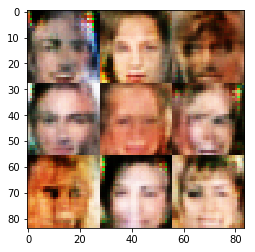

Epoch 1/1... Discriminator Loss: 1.2641... Generator Loss: 1.6360
Epoch 1/1... Discriminator Loss: 1.1581... Generator Loss: 2.2527
Epoch 1/1... Discriminator Loss: 1.0555... Generator Loss: 0.7960
Epoch 1/1... Discriminator Loss: 0.8861... Generator Loss: 2.0344
Epoch 1/1... Discriminator Loss: 0.8407... Generator Loss: 2.4050
Epoch 1/1... Discriminator Loss: 1.3075... Generator Loss: 0.9849
Epoch 1/1... Discriminator Loss: 1.1476... Generator Loss: 0.7103
Epoch 1/1... Discriminator Loss: 1.0675... Generator Loss: 0.7378
Epoch 1/1... Discriminator Loss: 0.7104... Generator Loss: 1.9375
Epoch 1/1... Discriminator Loss: 0.6921... Generator Loss: 1.9521


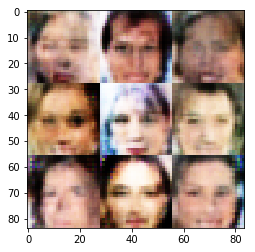

Epoch 1/1... Discriminator Loss: 1.3500... Generator Loss: 0.8227
Epoch 1/1... Discriminator Loss: 1.1080... Generator Loss: 1.4069
Epoch 1/1... Discriminator Loss: 1.0458... Generator Loss: 0.8642
Epoch 1/1... Discriminator Loss: 0.9236... Generator Loss: 1.3549
Epoch 1/1... Discriminator Loss: 1.5891... Generator Loss: 2.6319
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.5923
Epoch 1/1... Discriminator Loss: 1.2403... Generator Loss: 0.7889
Epoch 1/1... Discriminator Loss: 1.1068... Generator Loss: 0.7340
Epoch 1/1... Discriminator Loss: 1.1122... Generator Loss: 0.9389
Epoch 1/1... Discriminator Loss: 1.8090... Generator Loss: 1.8876


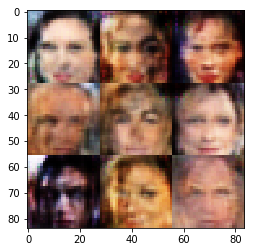

Epoch 1/1... Discriminator Loss: 1.1072... Generator Loss: 0.7450
Epoch 1/1... Discriminator Loss: 0.9008... Generator Loss: 1.1565
Epoch 1/1... Discriminator Loss: 1.2165... Generator Loss: 0.8224
Epoch 1/1... Discriminator Loss: 1.1584... Generator Loss: 1.2454
Epoch 1/1... Discriminator Loss: 1.0444... Generator Loss: 1.0771
Epoch 1/1... Discriminator Loss: 1.1723... Generator Loss: 1.6895
Epoch 1/1... Discriminator Loss: 0.7830... Generator Loss: 1.8471
Epoch 1/1... Discriminator Loss: 1.0399... Generator Loss: 0.8156
Epoch 1/1... Discriminator Loss: 1.6197... Generator Loss: 2.0790
Epoch 1/1... Discriminator Loss: 0.9363... Generator Loss: 0.9969


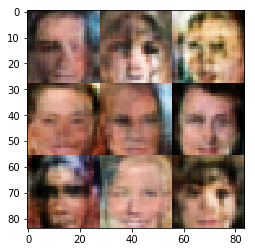

Epoch 1/1... Discriminator Loss: 1.1809... Generator Loss: 0.6383
Epoch 1/1... Discriminator Loss: 0.8921... Generator Loss: 1.5843
Epoch 1/1... Discriminator Loss: 0.8146... Generator Loss: 1.2989
Epoch 1/1... Discriminator Loss: 1.3232... Generator Loss: 0.6431
Epoch 1/1... Discriminator Loss: 1.2427... Generator Loss: 0.6155
Epoch 1/1... Discriminator Loss: 1.1452... Generator Loss: 1.3825
Epoch 1/1... Discriminator Loss: 1.8349... Generator Loss: 0.3053
Epoch 1/1... Discriminator Loss: 0.7019... Generator Loss: 1.7817
Epoch 1/1... Discriminator Loss: 0.8822... Generator Loss: 1.4155
Epoch 1/1... Discriminator Loss: 1.6844... Generator Loss: 0.3271


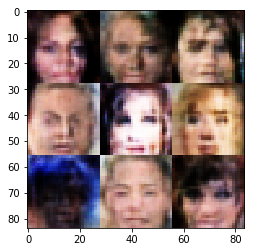

Epoch 1/1... Discriminator Loss: 0.8277... Generator Loss: 1.4023
Epoch 1/1... Discriminator Loss: 1.1855... Generator Loss: 0.6497
Epoch 1/1... Discriminator Loss: 1.0793... Generator Loss: 0.7275
Epoch 1/1... Discriminator Loss: 1.1323... Generator Loss: 0.6544
Epoch 1/1... Discriminator Loss: 1.1960... Generator Loss: 0.6893
Epoch 1/1... Discriminator Loss: 0.9424... Generator Loss: 1.7082
Epoch 1/1... Discriminator Loss: 0.8330... Generator Loss: 1.6660
Epoch 1/1... Discriminator Loss: 1.0011... Generator Loss: 0.8560
Epoch 1/1... Discriminator Loss: 1.2340... Generator Loss: 0.7323
Epoch 1/1... Discriminator Loss: 1.1677... Generator Loss: 1.6291


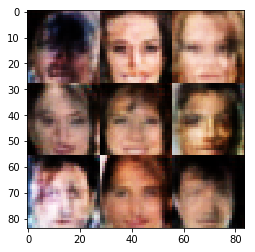

Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 1.3484
Epoch 1/1... Discriminator Loss: 0.7785... Generator Loss: 2.5233
Epoch 1/1... Discriminator Loss: 1.6003... Generator Loss: 0.3720
Epoch 1/1... Discriminator Loss: 0.8392... Generator Loss: 1.8592
Epoch 1/1... Discriminator Loss: 0.9492... Generator Loss: 1.0246
Epoch 1/1... Discriminator Loss: 1.1819... Generator Loss: 0.6484
Epoch 1/1... Discriminator Loss: 1.3474... Generator Loss: 1.5005
Epoch 1/1... Discriminator Loss: 1.5248... Generator Loss: 2.0049
Epoch 1/1... Discriminator Loss: 1.0220... Generator Loss: 0.9245
Epoch 1/1... Discriminator Loss: 0.7246... Generator Loss: 1.4157


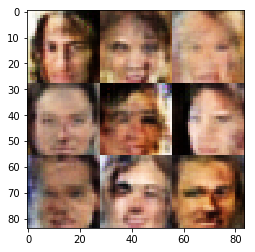

Epoch 1/1... Discriminator Loss: 1.5892... Generator Loss: 2.3591
Epoch 1/1... Discriminator Loss: 1.1727... Generator Loss: 0.7210
Epoch 1/1... Discriminator Loss: 1.1252... Generator Loss: 1.2561
Epoch 1/1... Discriminator Loss: 0.7949... Generator Loss: 2.1184
Epoch 1/1... Discriminator Loss: 1.3301... Generator Loss: 1.8500
Epoch 1/1... Discriminator Loss: 1.0839... Generator Loss: 0.7179
Epoch 1/1... Discriminator Loss: 0.8378... Generator Loss: 1.1282
Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 0.5641
Epoch 1/1... Discriminator Loss: 0.9064... Generator Loss: 1.2686
Epoch 1/1... Discriminator Loss: 0.9367... Generator Loss: 0.9857


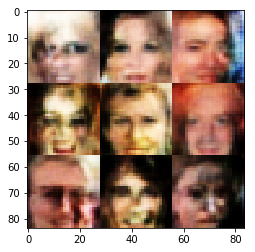

Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.5908
Epoch 1/1... Discriminator Loss: 0.9733... Generator Loss: 1.0747
Epoch 1/1... Discriminator Loss: 1.0556... Generator Loss: 1.1925
Epoch 1/1... Discriminator Loss: 1.0948... Generator Loss: 0.9140
Epoch 1/1... Discriminator Loss: 0.8797... Generator Loss: 1.3044
Epoch 1/1... Discriminator Loss: 0.7652... Generator Loss: 2.1678
Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.6017
Epoch 1/1... Discriminator Loss: 1.2761... Generator Loss: 1.9534
Epoch 1/1... Discriminator Loss: 0.8428... Generator Loss: 1.0939
Epoch 1/1... Discriminator Loss: 1.3033... Generator Loss: 0.5765


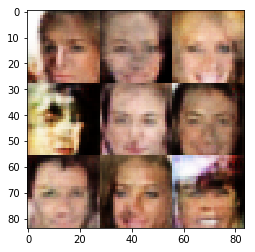

Epoch 1/1... Discriminator Loss: 0.9128... Generator Loss: 2.1773
Epoch 1/1... Discriminator Loss: 1.1778... Generator Loss: 0.6488
Epoch 1/1... Discriminator Loss: 0.6621... Generator Loss: 1.6480
Epoch 1/1... Discriminator Loss: 0.8484... Generator Loss: 1.6345
Epoch 1/1... Discriminator Loss: 1.2160... Generator Loss: 0.6316
Epoch 1/1... Discriminator Loss: 0.8809... Generator Loss: 0.9378
Epoch 1/1... Discriminator Loss: 0.5777... Generator Loss: 2.0843
Epoch 1/1... Discriminator Loss: 0.7249... Generator Loss: 1.8801
Epoch 1/1... Discriminator Loss: 1.1235... Generator Loss: 0.7593
Epoch 1/1... Discriminator Loss: 1.1968... Generator Loss: 0.9966


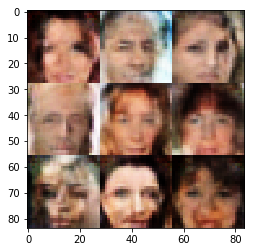

Epoch 1/1... Discriminator Loss: 1.5179... Generator Loss: 0.4213
Epoch 1/1... Discriminator Loss: 1.0460... Generator Loss: 1.0211
Epoch 1/1... Discriminator Loss: 2.4320... Generator Loss: 0.1523
Epoch 1/1... Discriminator Loss: 0.9534... Generator Loss: 0.9881
Epoch 1/1... Discriminator Loss: 1.1806... Generator Loss: 0.8892
Epoch 1/1... Discriminator Loss: 1.3080... Generator Loss: 0.5305
Epoch 1/1... Discriminator Loss: 0.8210... Generator Loss: 1.9798
Epoch 1/1... Discriminator Loss: 1.0260... Generator Loss: 0.9690
Epoch 1/1... Discriminator Loss: 1.2403... Generator Loss: 0.6629
Epoch 1/1... Discriminator Loss: 0.7955... Generator Loss: 1.3966


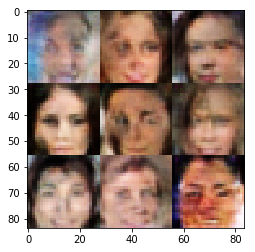

Epoch 1/1... Discriminator Loss: 1.8312... Generator Loss: 0.2884
Epoch 1/1... Discriminator Loss: 0.8134... Generator Loss: 1.3441
Epoch 1/1... Discriminator Loss: 0.6292... Generator Loss: 1.7730
Epoch 1/1... Discriminator Loss: 1.2414... Generator Loss: 0.6351
Epoch 1/1... Discriminator Loss: 1.0855... Generator Loss: 0.9627
Epoch 1/1... Discriminator Loss: 1.2984... Generator Loss: 1.5973
Epoch 1/1... Discriminator Loss: 1.4418... Generator Loss: 0.4576
Epoch 1/1... Discriminator Loss: 1.4742... Generator Loss: 2.2007
Epoch 1/1... Discriminator Loss: 0.9255... Generator Loss: 0.9567
Epoch 1/1... Discriminator Loss: 1.0172... Generator Loss: 1.0576


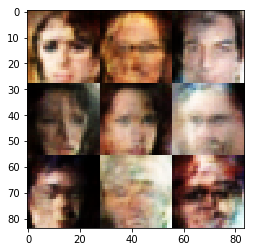

Epoch 1/1... Discriminator Loss: 1.1863... Generator Loss: 0.8351
Epoch 1/1... Discriminator Loss: 1.1644... Generator Loss: 0.6994
Epoch 1/1... Discriminator Loss: 1.1245... Generator Loss: 1.0797
Epoch 1/1... Discriminator Loss: 1.0230... Generator Loss: 1.3321
Epoch 1/1... Discriminator Loss: 0.8854... Generator Loss: 1.4821
Epoch 1/1... Discriminator Loss: 1.9296... Generator Loss: 2.8339
Epoch 1/1... Discriminator Loss: 0.9533... Generator Loss: 1.3358
Epoch 1/1... Discriminator Loss: 0.9615... Generator Loss: 1.3992
Epoch 1/1... Discriminator Loss: 1.0202... Generator Loss: 1.8033
Epoch 1/1... Discriminator Loss: 1.0567... Generator Loss: 0.8200


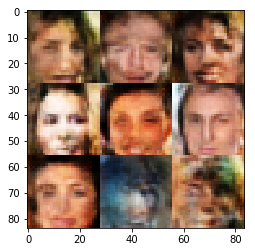

Epoch 1/1... Discriminator Loss: 1.7278... Generator Loss: 0.3334
Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.5210
Epoch 1/1... Discriminator Loss: 1.1040... Generator Loss: 1.2881
Epoch 1/1... Discriminator Loss: 1.1480... Generator Loss: 0.6509
Epoch 1/1... Discriminator Loss: 1.9794... Generator Loss: 2.1475
Epoch 1/1... Discriminator Loss: 1.1003... Generator Loss: 1.1501
Epoch 1/1... Discriminator Loss: 0.8641... Generator Loss: 1.0475
Epoch 1/1... Discriminator Loss: 1.2431... Generator Loss: 0.6727
Epoch 1/1... Discriminator Loss: 1.7559... Generator Loss: 1.8381
Epoch 1/1... Discriminator Loss: 0.8286... Generator Loss: 1.2439


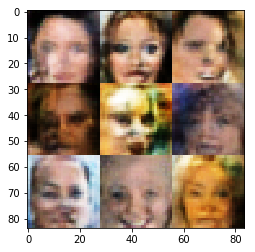

Epoch 1/1... Discriminator Loss: 0.9861... Generator Loss: 1.0104
Epoch 1/1... Discriminator Loss: 0.9583... Generator Loss: 1.5904
Epoch 1/1... Discriminator Loss: 1.0581... Generator Loss: 1.3708
Epoch 1/1... Discriminator Loss: 0.9059... Generator Loss: 1.4344
Epoch 1/1... Discriminator Loss: 1.5450... Generator Loss: 0.4070
Epoch 1/1... Discriminator Loss: 0.7667... Generator Loss: 1.3761
Epoch 1/1... Discriminator Loss: 1.4851... Generator Loss: 0.4307
Epoch 1/1... Discriminator Loss: 1.1549... Generator Loss: 0.6947
Epoch 1/1... Discriminator Loss: 0.7608... Generator Loss: 1.5329
Epoch 1/1... Discriminator Loss: 1.0962... Generator Loss: 0.7467


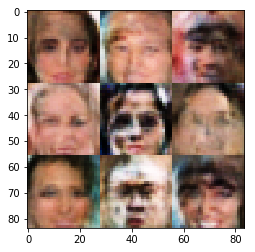

Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 0.5492
Epoch 1/1... Discriminator Loss: 1.0618... Generator Loss: 2.1443
Epoch 1/1... Discriminator Loss: 0.9292... Generator Loss: 1.1687
Epoch 1/1... Discriminator Loss: 0.7262... Generator Loss: 1.9486
Epoch 1/1... Discriminator Loss: 1.5645... Generator Loss: 1.9798
Epoch 1/1... Discriminator Loss: 1.5556... Generator Loss: 1.7651
Epoch 1/1... Discriminator Loss: 1.2827... Generator Loss: 2.1021
Epoch 1/1... Discriminator Loss: 1.0052... Generator Loss: 0.8680
Epoch 1/1... Discriminator Loss: 1.6918... Generator Loss: 0.3511
Epoch 1/1... Discriminator Loss: 1.1906... Generator Loss: 0.7037


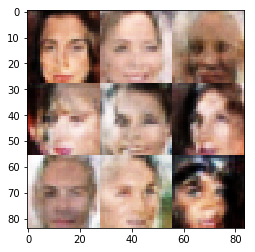

Epoch 1/1... Discriminator Loss: 0.7804... Generator Loss: 1.3407
Epoch 1/1... Discriminator Loss: 1.2081... Generator Loss: 0.6090
Epoch 1/1... Discriminator Loss: 0.9678... Generator Loss: 1.8203
Epoch 1/1... Discriminator Loss: 1.0869... Generator Loss: 0.8064
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 1.4367
Epoch 1/1... Discriminator Loss: 1.0412... Generator Loss: 1.1710
Epoch 1/1... Discriminator Loss: 0.8486... Generator Loss: 1.4922
Epoch 1/1... Discriminator Loss: 1.3416... Generator Loss: 0.5066
Epoch 1/1... Discriminator Loss: 0.9038... Generator Loss: 0.9839
Epoch 1/1... Discriminator Loss: 0.9656... Generator Loss: 1.0587


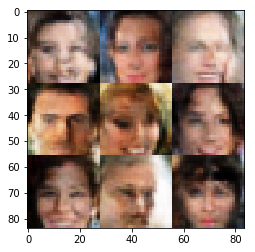

Epoch 1/1... Discriminator Loss: 0.9529... Generator Loss: 0.9627
Epoch 1/1... Discriminator Loss: 1.1226... Generator Loss: 1.5650
Epoch 1/1... Discriminator Loss: 1.5063... Generator Loss: 1.9236
Epoch 1/1... Discriminator Loss: 0.8374... Generator Loss: 1.6865
Epoch 1/1... Discriminator Loss: 0.9073... Generator Loss: 1.9918
Epoch 1/1... Discriminator Loss: 1.0296... Generator Loss: 2.0562
Epoch 1/1... Discriminator Loss: 1.5631... Generator Loss: 1.9856
Epoch 1/1... Discriminator Loss: 1.8013... Generator Loss: 0.2999
Epoch 1/1... Discriminator Loss: 1.2116... Generator Loss: 0.6220
Epoch 1/1... Discriminator Loss: 0.7274... Generator Loss: 1.6082


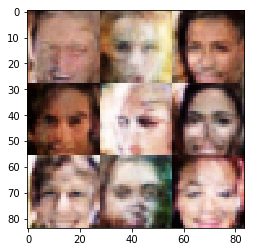

Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.4830
Epoch 1/1... Discriminator Loss: 0.8022... Generator Loss: 1.2079
Epoch 1/1... Discriminator Loss: 1.0248... Generator Loss: 1.6127
Epoch 1/1... Discriminator Loss: 1.1788... Generator Loss: 0.8707
Epoch 1/1... Discriminator Loss: 0.9488... Generator Loss: 0.9739
Epoch 1/1... Discriminator Loss: 1.5444... Generator Loss: 2.1584
Epoch 1/1... Discriminator Loss: 1.2643... Generator Loss: 0.9018
Epoch 1/1... Discriminator Loss: 1.2573... Generator Loss: 0.5886
Epoch 1/1... Discriminator Loss: 1.0240... Generator Loss: 0.8314
Epoch 1/1... Discriminator Loss: 1.1384... Generator Loss: 0.7874


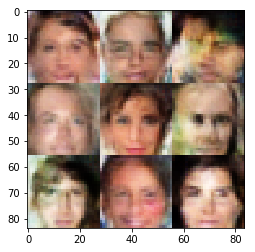

Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 0.4622
Epoch 1/1... Discriminator Loss: 1.0199... Generator Loss: 1.5038
Epoch 1/1... Discriminator Loss: 1.1983... Generator Loss: 0.6480
Epoch 1/1... Discriminator Loss: 0.9549... Generator Loss: 1.1687
Epoch 1/1... Discriminator Loss: 2.1303... Generator Loss: 0.2348
Epoch 1/1... Discriminator Loss: 0.9778... Generator Loss: 0.9776
Epoch 1/1... Discriminator Loss: 1.1419... Generator Loss: 0.7022
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.5681
Epoch 1/1... Discriminator Loss: 1.0526... Generator Loss: 1.1818
Epoch 1/1... Discriminator Loss: 1.2012... Generator Loss: 1.9741


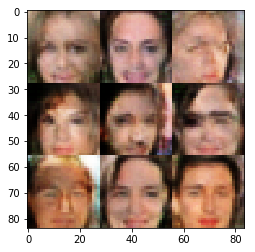

Epoch 1/1... Discriminator Loss: 1.0972... Generator Loss: 1.0475
Epoch 1/1... Discriminator Loss: 1.1124... Generator Loss: 0.7605
Epoch 1/1... Discriminator Loss: 0.9372... Generator Loss: 1.2814
Epoch 1/1... Discriminator Loss: 0.9948... Generator Loss: 1.7225
Epoch 1/1... Discriminator Loss: 1.0277... Generator Loss: 2.0817
Epoch 1/1... Discriminator Loss: 1.2374... Generator Loss: 0.5858
Epoch 1/1... Discriminator Loss: 0.7781... Generator Loss: 1.3261
Epoch 1/1... Discriminator Loss: 0.9253... Generator Loss: 1.1801
Epoch 1/1... Discriminator Loss: 0.7753... Generator Loss: 1.2650
Epoch 1/1... Discriminator Loss: 1.2851... Generator Loss: 0.5553


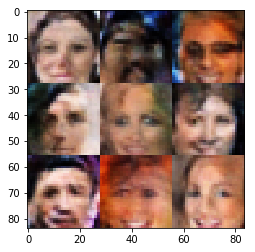

Epoch 1/1... Discriminator Loss: 1.0154... Generator Loss: 1.4249
Epoch 1/1... Discriminator Loss: 0.7757... Generator Loss: 1.1506
Epoch 1/1... Discriminator Loss: 1.3476... Generator Loss: 0.6001
Epoch 1/1... Discriminator Loss: 0.9256... Generator Loss: 0.9513
Epoch 1/1... Discriminator Loss: 1.3083... Generator Loss: 0.6545
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.5427


In [143]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.